## Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, List
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, \
    roc_auc_score, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from yellowbrick.cluster import KElbowVisualizer
from pandas.io.formats import style
from itertools import cycle
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
def load_dataset(path: str) -> pd.DataFrame:
    return pd.read_csv(path, engine='pyarrow', dtype_backend='pyarrow')


PATH = os.getcwd() + '/data/Clustered_Customer_Data.csv'
data = load_dataset(PATH)

In [3]:
# Preprocessing
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df.drop(columns=[''], inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


data = preprocess(data)

## Data and Methods

**Information about the data**
- ```BALANCE```: Balance amount left in their account to make purchases
- ```BALANCE_FREQUENCY```: How frequently the Balance is updated, score between ```0``` and ```1``` (```1``` = frequently updated, ```0``` = not frequently updated)
- ```PURCHASES```: Amount of purchases made from account
- ```ONEOFF_PURCHASES```: Maximum purchase amount done in one-go
- ```INSTALLMENTS_PURCHASES```: Amount of purchase done in installment
- ```CASH_ADVANCE```: Cash in advance given by the user
- ```PURCHASES_FREQUENCY```: How frequently the Purchases are being made, score between ```0``` and ```1``` (```1``` = frequently purchased, ```0``` = not frequently purchased)
- ```ONEOFFPURCHASESFREQUENCY```: How frequently Purchases are happening in one-go (```1``` = frequently purchased, ```0``` = not frequently purchased)
- ```PURCHASESINSTALLMENTSFREQUENCY```: How frequently purchases in installments are being done (```1``` = frequently done, ```0``` = not frequently done)
- ```CASHADVANCEFREQUENCY```: How frequently the cash in advance being paid
- ```CASHADVANCETRX```: Number of Transactions made with "Cash in Advanced"
- ```PURCHASES_TRX```: Numbe of purchase transactions made
- ```CREDIT_LIMIT```: Limit of Credit Card for user
- ```PAYMENTS```: Amount of Payment done by user
- ```MINIMUM_PAYMENTS```: Minimum amount of payments made by user
- ```PRCFULLPAYMENT```: Percent of full payment paid by user
- ```TENURE```: Tenure of credit card service for user
- ```Cluster```: Cluster ID (```0```-```3```)

**Remarks on the dataset**
- The dataset contains 8950 rows and 18 columns, with no missing values or duplicates. All columns are positive numeric values. To prevent data leakage, we will retain the outliers in the dataset.

**Methods:**
Our exploratory data analysis involved various methodologies, including data cleaning, data visualization, statistical analysis, and machine learning algorithms. To clean the data, we used Pandas to handle missing values, and outliers, and transform variables as necessary. We also used Scikit-learn tools, such as StandardScaler, to prepare the data for machine learning algorithms. For visualization, we employed Matplotlib and Seaborn to create various plots, including barplots, lineplots, and heat maps, to identify patterns and relationships. Additionally, we utilized the Scipy library for statistical analysis, including the Chi-square test to understand relationships between variables. For machine learning, we implemented various algorithms, such as k-Nearest Neighbors, k-Means Clustering, and Random Forests, and evaluated the models based on accuracy, precision, recall, F1 score, and cross-validation.

In [4]:
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   BALANCE                           8950 non-null   double[pyarrow]
 1   BALANCE_FREQUENCY                 8950 non-null   double[pyarrow]
 2   PURCHASES                         8950 non-null   double[pyarrow]
 3   ONEOFF_PURCHASES                  8950 non-null   double[pyarrow]
 4   INSTALLMENTS_PURCHASES            8950 non-null   double[pyarrow]
 5   CASH_ADVANCE                      8950 non-null   double[pyarrow]
 6   PURCHASES_FREQUENCY               8950 non-null   double[pyarrow]
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   double[pyarrow]
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   double[pyarrow]
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   double[pyarrow]
 10  CASH_ADVANCE_TRX                  89

## Exploratory Data Analysis

In [6]:
eda = data.copy()

In [ ]:
# Plotting the distribution of the data
def plot_distribution(df: pd.DataFrame) -> None:
    sns.set_palette('BuGn_r')
    fig, axes = plt.subplots(6, 3, figsize=(17, 17))

    columns: List[str] = df.columns.to_list()
    for ax, col in zip(axes.flatten(), columns):
        sns.kdeplot(df[col], ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.tight_layout()
    plt.show()


plot_distribution(eda)

In [8]:
# Table of basic statistics
def basic_statistics(df: pd.DataFrame) -> style.Styler:
    return df.describe().T.style.background_gradient(cmap='Paired') \
        .set_properties(**{'font-size': '10pt',
                           'width': '100px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 1. Basic Statistics of the Data')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')


basic_statistics(eda)

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.000000,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.138560
BALANCE_FREQUENCY,8950.000000,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.000000
PURCHASES,8950.000000,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.570000
ONEOFF_PURCHASES,8950.000000,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.250000
INSTALLMENTS_PURCHASES,8950.000000,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.000000
CASH_ADVANCE,8950.000000,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.211760
PURCHASES_FREQUENCY,8950.000000,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.000000,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.000000,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.000000
CASH_ADVANCE_FREQUENCY,8950.000000,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.500000


In [9]:
# Table of the number of outliers
def outliers(df: pd.DataFrame) -> style.Styler:
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() \
        .to_frame('number_of_outliers').style.background_gradient(cmap='Paired') \
        .set_properties(**{'font-size': '10pt',
                           'width': '100px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 2. Number of outliers')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')


outliers(eda)

,number_of_outliers
BALANCE,695
BALANCE_FREQUENCY,1493
PURCHASES,808
ONEOFF_PURCHASES,1013
INSTALLMENTS_PURCHASES,867
CASH_ADVANCE,1030
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,782
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,525


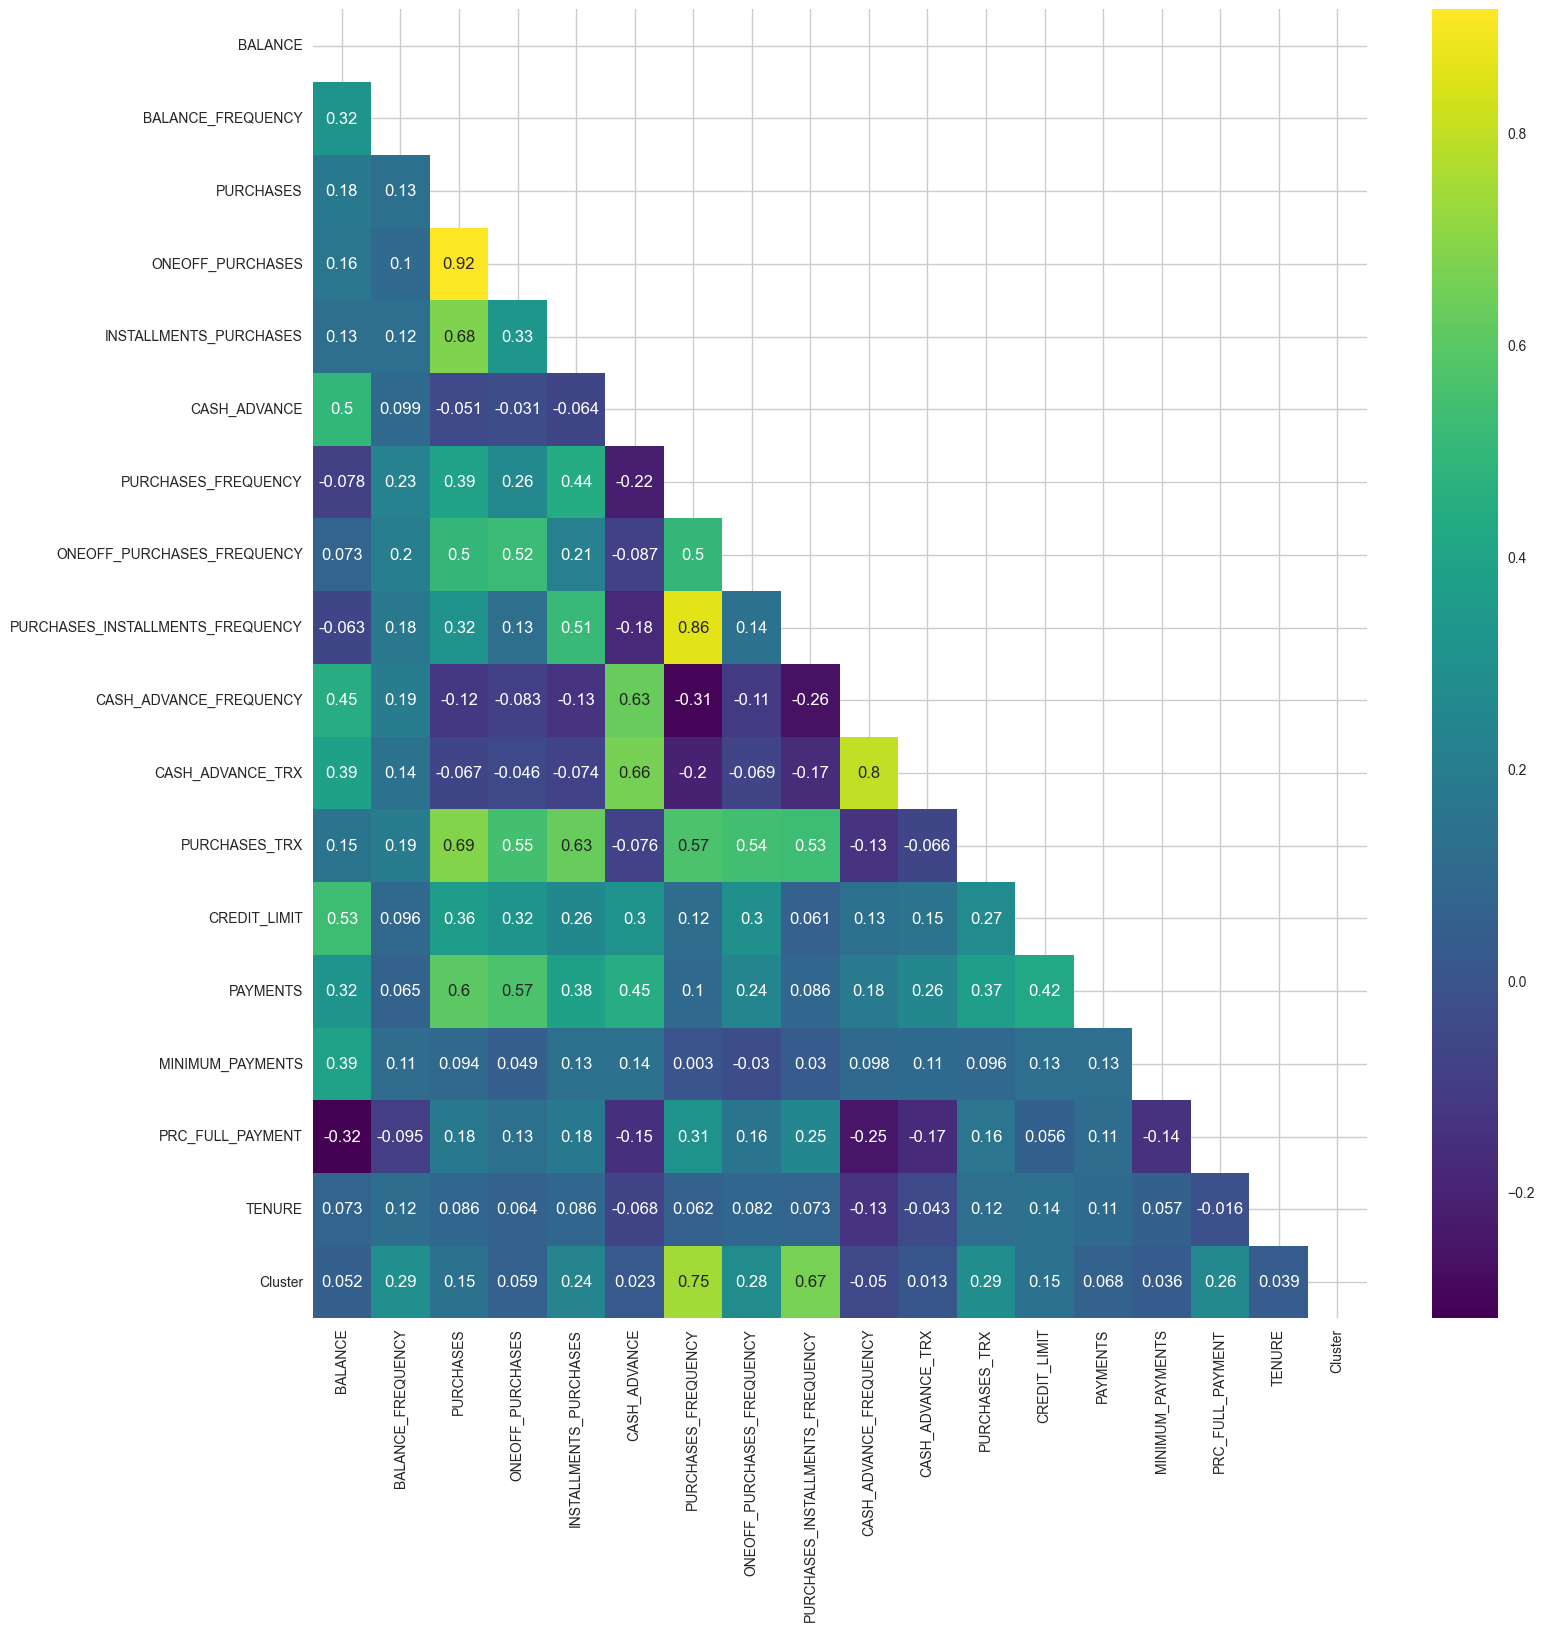

In [10]:
# Plotting the correlation matrix
def plot_correlation_matrix(df: pd.DataFrame) -> None:
    corr = df.corr()

    _, ax = plt.subplots(figsize=(17, 17))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(df.corr(), annot=True, ax=ax, cmap='viridis', mask=mask)

    plt.show()


plot_correlation_matrix(eda)

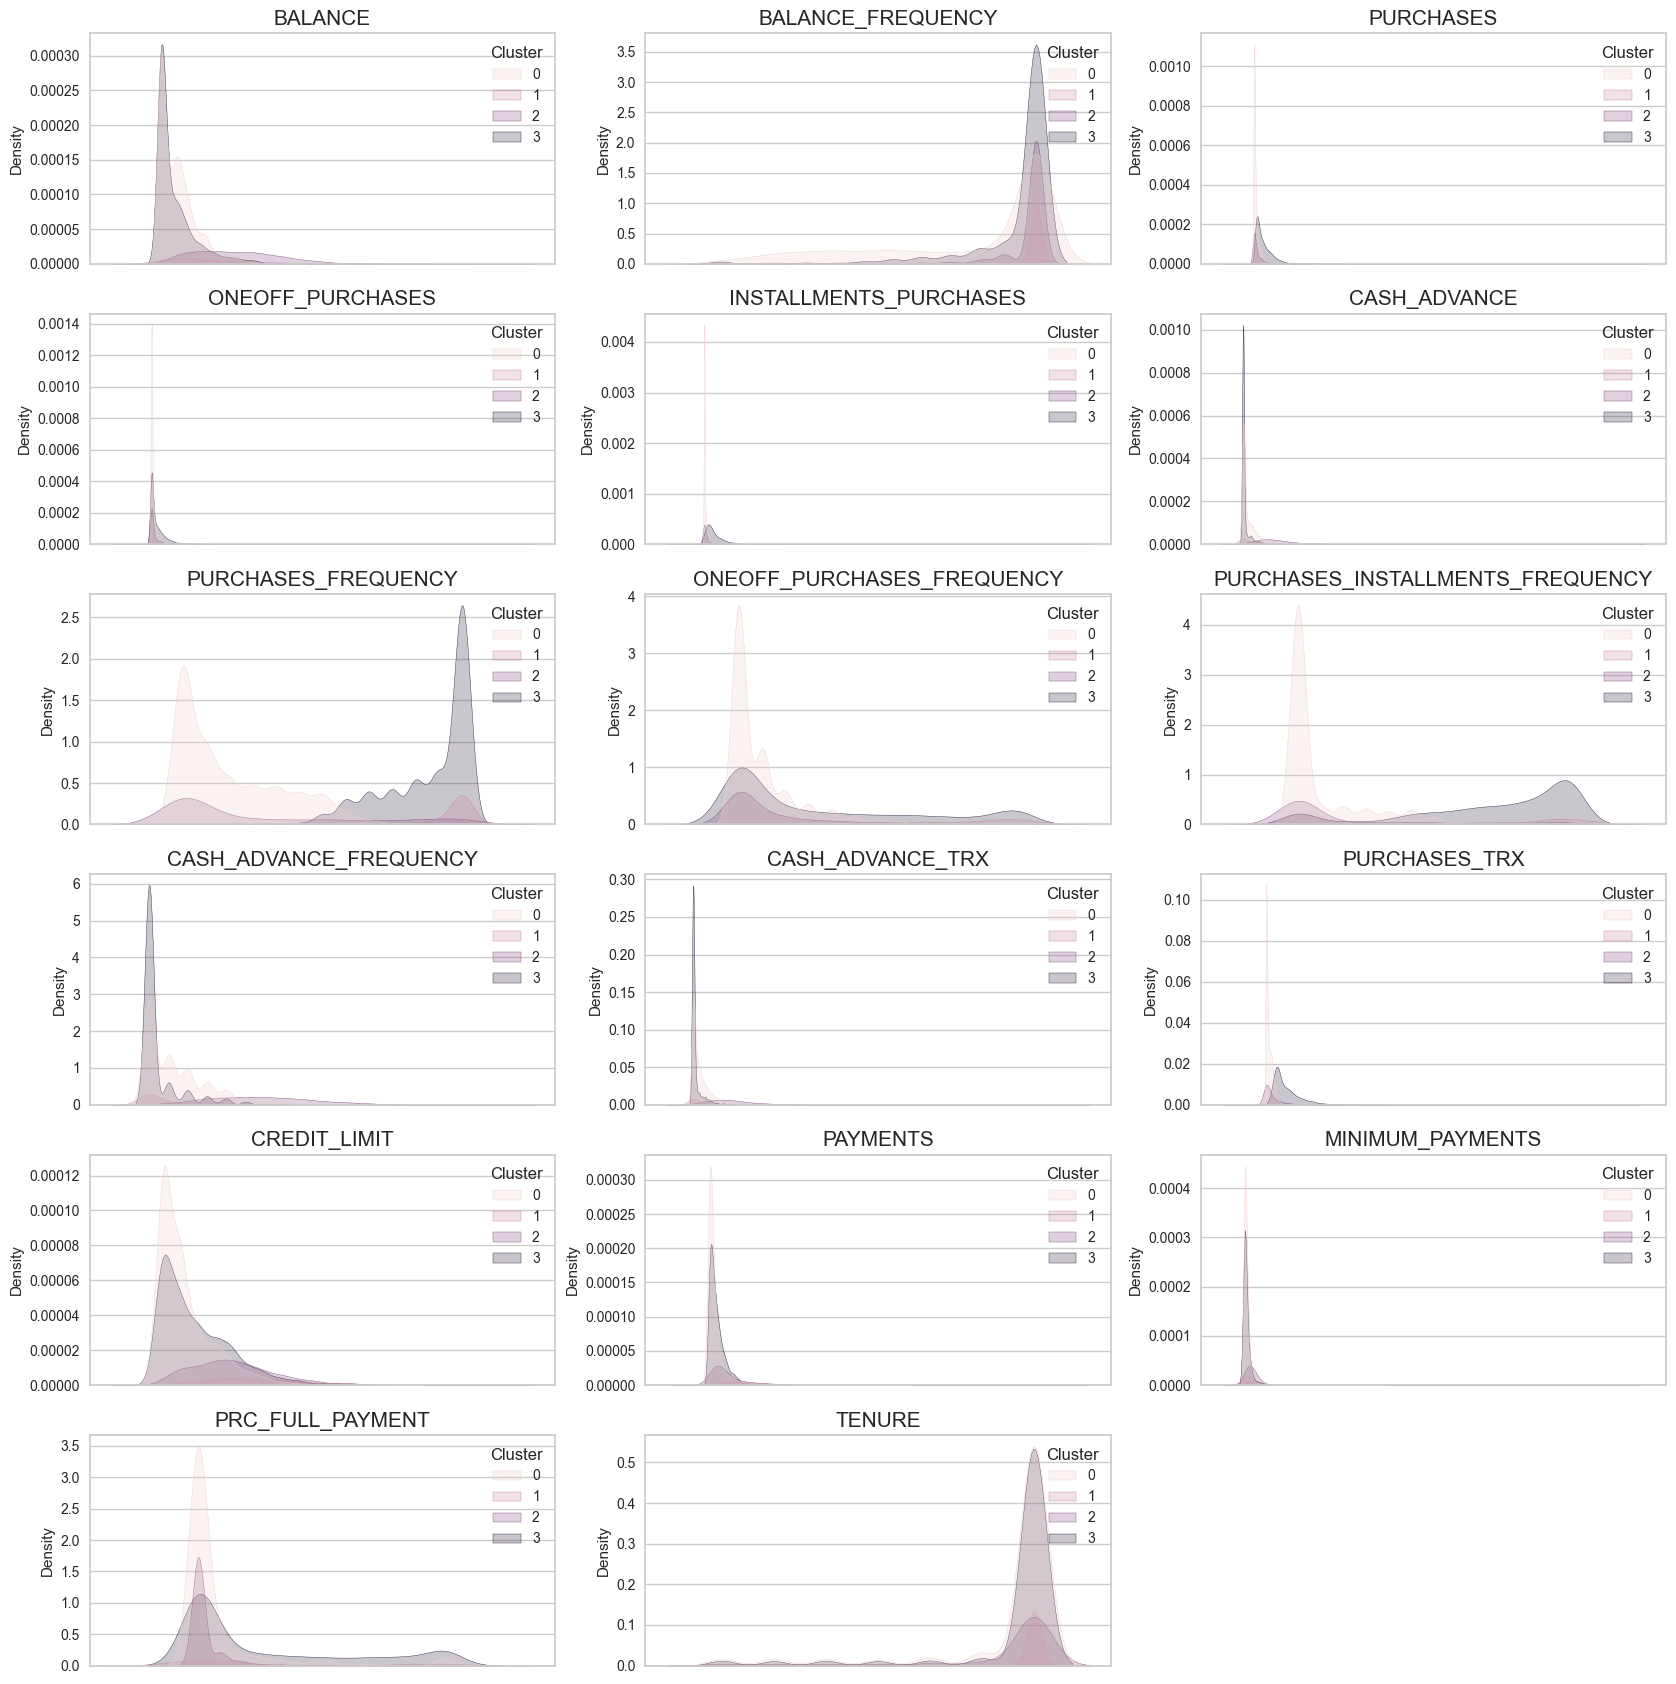

In [11]:
# Plotting the distribution of the data by clusters
def plot_distribution_by_clusters(df: pd.DataFrame) -> None:
    sns.set_palette('Paired')
    fig, axes = plt.subplots(6, 3, figsize=(17, 17))
    axes[-1, -1].axis('off')

    columns: List[str] = df.columns.delete(-1).to_list()
    for ax, col in zip(axes.flatten(), columns):
        sns.kdeplot(df, x=col, hue='Cluster', ax=ax, fill=True)
        ax.set_title(col, fontsize=15)
        ax.set_xlabel('')
        ax.set_xticks([])

    fig.tight_layout()
    plt.show()


plot_distribution_by_clusters(eda)

## Machine Learning

### Feature Engineering

In [12]:
ml = data.copy()
X = ml.drop(columns=['Cluster'])
Y = label_binarize(ml['Cluster'], classes=[0, 1, 2, 3])
n_classes = Y.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Model Selection

#### K-Nearest Neighbors vs Logistic Regression vs Random Forests

In [13]:
# Create pipelines
def create_pipelines() -> Dict[str, OneVsRestClassifier]:
    return {
        'K Nearest Neighbors': OneVsRestClassifier(make_pipeline(StandardScaler(), KNeighborsClassifier())),
        'Logistic Regression': OneVsRestClassifier(make_pipeline(StandardScaler(), LogisticRegression())),
        'Random Forest': OneVsRestClassifier(make_pipeline(StandardScaler(), RandomForestClassifier()))
    }


pipelines = create_pipelines()

In [14]:
# Get metrics from pipelines
def metrics_from_pipelines(x_train: pd.DataFrame,
                           y_train: pd.Series,
                           x_test: pd.DataFrame,
                           y_test: pd.Series) -> style.Styler:
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_aps = []
    train_precs = []
    train_recs = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_aps = []
    test_precs = []
    test_recs = []

    for _, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        y_pred_test = pipeline.predict(x_test)
        y_pred_train = pipeline.predict(x_train)

        y_probs_test = pipeline.predict_proba(x_test)
        y_probs_train = pipeline.predict_proba(x_train)

        train_roc_aucs.append(roc_auc_score(
            y_train, y_probs_train, multi_class='ovr'))
        test_roc_aucs.append(roc_auc_score(
            y_test, y_probs_test, multi_class='ovr'))

        train_aps.append(average_precision_score(y_train, y_probs_train, average='weighted'))
        test_aps.append(average_precision_score(y_test, y_probs_test, average='weighted'))

        train_accs.append(accuracy_score(y_train, y_pred_train))
        test_accs.append(accuracy_score(y_test, y_pred_test))

        train_f1s.append(f1_score(y_train, y_pred_train, average='weighted'))
        test_f1s.append(f1_score(y_test, y_pred_test, average='weighted'))

        train_precs.append(precision_score(
            y_train, y_pred_train, average='weighted'))
        test_precs.append(precision_score(
            y_test, y_pred_test, average='weighted'))

        train_recs.append(recall_score(
            y_train, y_pred_train, average='weighted'))
        test_recs.append(recall_score(y_test, y_pred_test, average='weighted'))

    # Aggregate the performance metric lists into separate dataframes
    train_metrics = pd.DataFrame({
        'model': pipelines.keys(),
        'accuracy': train_accs,
        'f1_score': train_f1s,
        'roc_auc': train_roc_aucs,
        'ap': train_aps,
        'precision': train_precs,
        'recall': train_recs
    })

    test_metrics = pd.DataFrame({
        'model': pipelines.keys(),
        'accuracy': test_accs,
        'f1_score': test_f1s,
        'roc_auc': test_roc_aucs,
        'ap': test_aps,
        'precision': test_precs,
        'recall': test_recs
    })

    # Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))

    # Sorting coulmns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'ap_train',
                                                             'ap_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test'])

    return train_test_metrics.set_index('model').transpose().style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'width': '200px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 3. Model performance metrics')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')


metrics_from_pipelines(X_train, Y_train, X_test, Y_test)

model,K Nearest Neighbors,Logistic Regression,Random Forest
accuracy_train,0.970391,0.882263,1.000000
accuracy_test,0.950838,0.879330,0.946369
f1_score_train,0.971958,0.937924,1.000000
f1_score_test,0.952362,0.936353,0.957857
roc_auc_train,0.999078,0.994194,1.000000
roc_auc_test,0.988184,0.992792,0.997705
ap_train,0.996219,0.986983,1.000000
ap_test,0.981820,0.984552,0.993853
precision_train,0.973896,0.936497,1.000000
precision_test,0.954635,0.936509,0.964428


Table 3 display the scoring metrics of all three of our Machine Learning models. Analyzing the data, we can see that the Random Forest Classifier is suffering from over fitting, which means that the model has stored the training data too well, adapting too much to the specific features of this data and thus becoming unable to generalize to the new data. This can be seen from the fact that all scoring metrics scored perfect in the training set, while scoring significantly lower in the test set. This is an important sign that the model is unable to generalize well to new data, thus making it unreliable for real-life use.
<br/><br/>
On the other hand, the Logistic Regression model showed a small discrepancy between train and test set scores, indicating that the model may be prone to over fitting and not generalize well on new data. However, this difference is quite small, so the model may still be useful for our analysis.
<br/><br/>
Finally, the K Nearest Neighbors model scored almost identically in both data sets, making it the best candidate to pursue our analysis. This indicates that the model has learned to generalize well to the relationships between variables in the problem and could be reliable for real-life use.

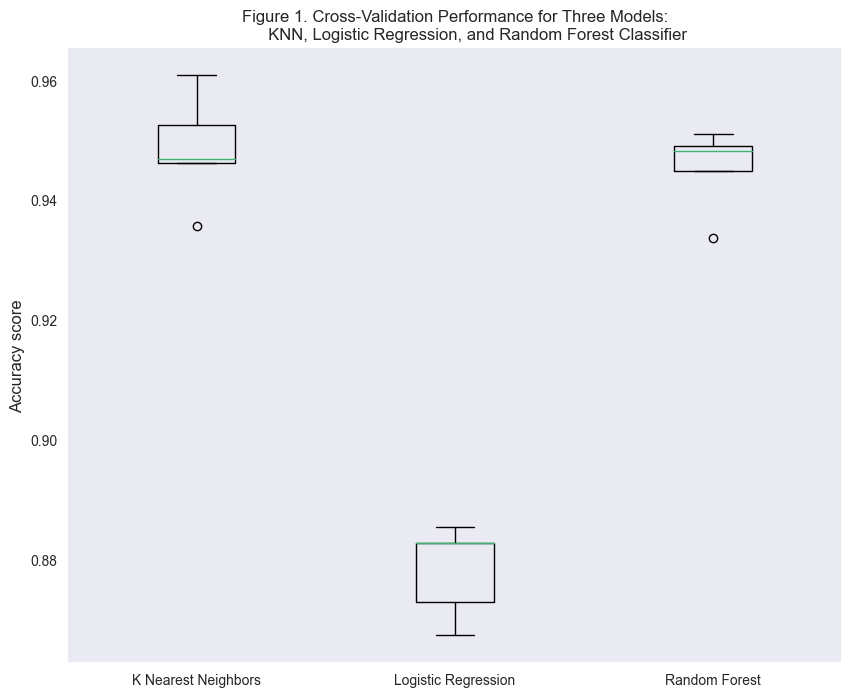

K Nearest Neighbors Test Set Accuracy: 0.9508379888268157
Logistic Regression Test Set Accuracy: 0.8793296089385475
Random Forest Test Set Accuracy: 0.9407821229050279


In [15]:
# Evaluating multiple models
def boxplot_cv_performances_from_pipes(x_train: pd.DataFrame,
                                       y_train: pd.Series,
                                       x_test: pd.DataFrame,
                                       y_test: pd.Series) -> None:
    results = []

    for pipeline in pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train, y_train, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('dark')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=list(pipelines.keys()),
                medianprops={'color': 'mediumseagreen'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.title('Figure 1. Cross-Validation Performance for Three Models:\n\
          KNN, Logistic Regression, and Random Forest Classifier')
    plt.show()

    # Test set performance
    for name, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        test_score = pipeline.score(x_test, y_test)
        print(f"{name} Test Set Accuracy: {test_score}")


boxplot_cv_performances_from_pipes(X_train, Y_train, X_test, Y_test)

As mentioned above, we can use different metrics to evaluate the performance of our model.
<br/><br/>
Figure 1 represents the distribution of accuracy scores (percentage of correct predictions) obtained by cross-validation, which divides the data set into several folders, using one folder as the validation set and the others as the training set. This process is repeated for each folder and finally, the results are combined, such as by calculating the mean, to obtain an estimate of the model performance. We can visually see what was expressed in table 2 confirming that Logistic regression has the best performance.
<br/><br/>
Another way is to use the ROC-AUC and PR-AUC curves to measure the ability of a classification model to discriminate between two classes, but they focus on different aspects.
<br/><br/>
The ROC curve represents the model's ability to discriminate between positive and negative classes. The ROC curve shows the relationship between the True Positive Rate (TPR), which is the percentage of true positives classified correctly to total positives, on the y-axis and the False Positive Rate (FPR), which is the percentage of false positives classified incorrectly to total negatives, on the x-axis. To create the curve, the model's classification threshold, which determines the cut-off point between positive and negative classes, is varied. At each threshold value, the corresponding TPR and FPR value is calculated and a point is drawn on the ROC curve. An ideal ROC curve should get as close as possible to the upper left side of the graph, indicating a high TPR and low FPR. The closer the ROC AUC value is to 1, the better the model's ability to distinguish between the two classes.
<br/><br/>
On the other hand, the PR curve represents the trade-off between Precision and Recall, highlighting the model's ability to find all positives (Recall) and classify them correctly (Precision), but does not account for negatives. The PR curve is obtained by plotting Precision on the y-axis and Recall on the x-axis. To construct the curve, one starts with the highest recall value 1 and calculates the corresponding precision. Then, you move to the right along the x-axis (i.e., decrease the recall value) and calculate the corresponding precision. You repeat the process until you arrive at the lowest recall value 0. An ideal PR curve should come as close as possible to the upper right side of the graph, indicating high Precision and high Recall.
<br/><br/>
Figure 2 below demonstrates that although all models performed better than the base rate, the worst-performing model concerning the ROC-AUC and PR-AUC metrics is K-Nearest Neighbors Classifier. Therefore, we decided to perform Hyperparameter tuning Logistic Regression to see if we are able to obtain better performance.

Figure 2. Test set area under the ROC curve and PR curve


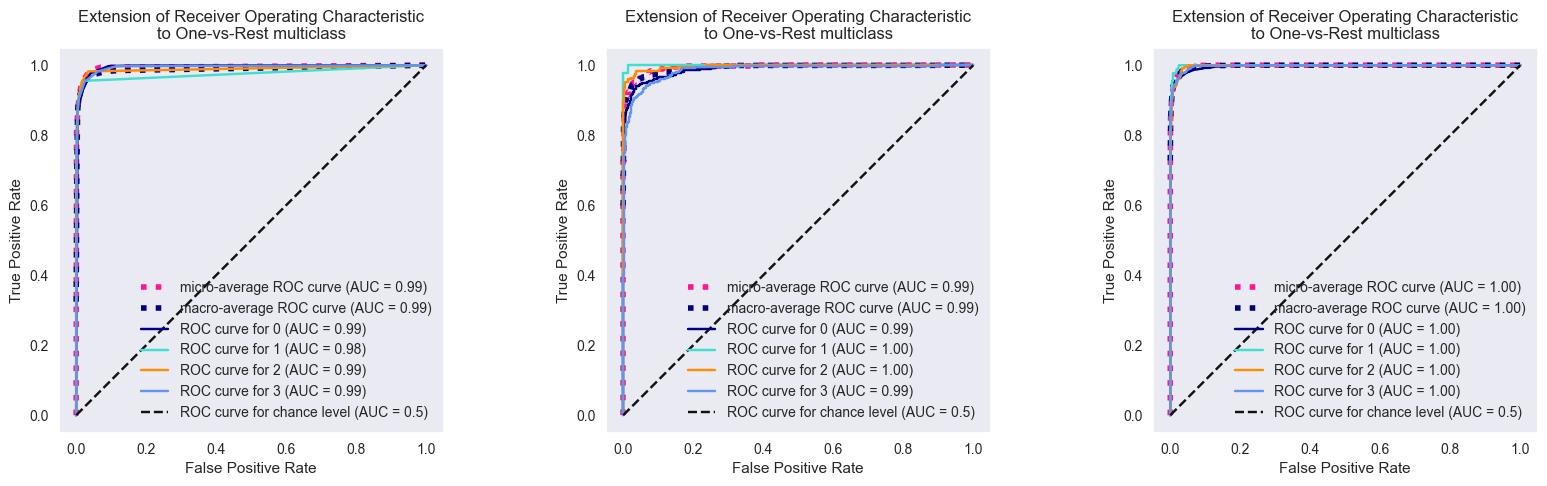

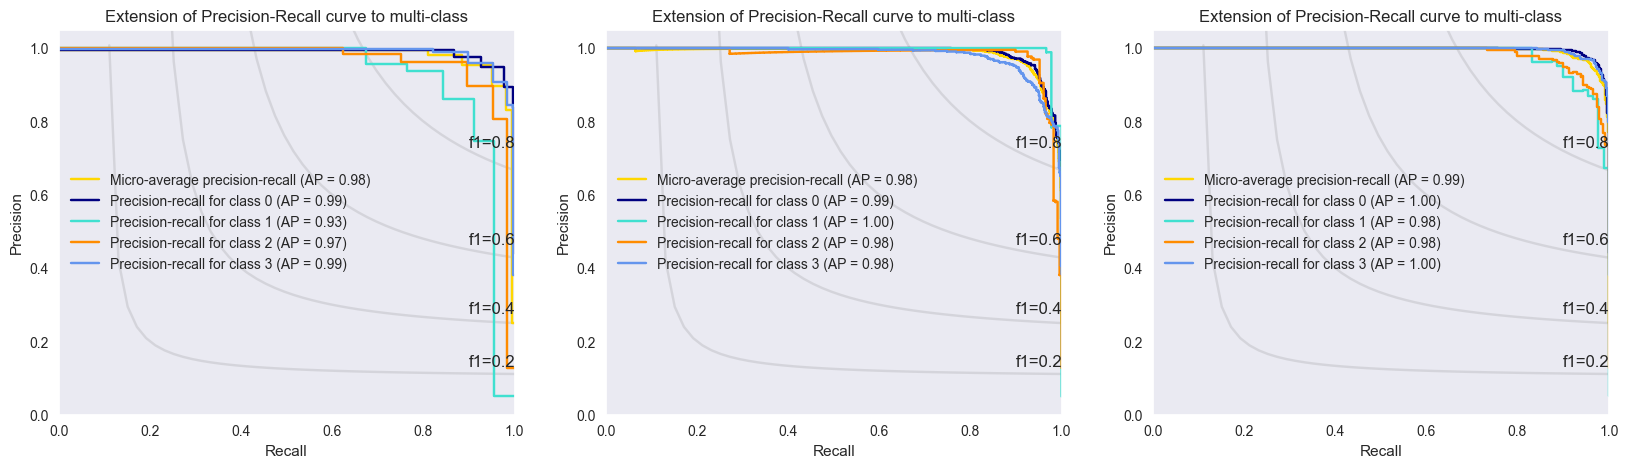

In [16]:
def roc_auc_curves_from_pipelines(x_train: pd.DataFrame,
                                  y_train: pd.Series,
                                  x_test: pd.DataFrame,
                                  y_test: pd.Series) -> None:
    fpr, tpr, roc_auc = {}, {}, {}

    _, axes = plt.subplots(1, 3, figsize=(20, 5))

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    for pipeline, ax in zip(pipelines.values(), axes):
        pipeline.fit(x_train, y_train)
        y_probs = pipeline.predict_proba(x_test)

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            # linear interpolation
            mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

        fpr['micro'], tpr['micro'], _ = roc_curve(
            y_test.ravel(), y_probs.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

        # Average it and compute AUC
        mean_tpr /= n_classes
        fpr['macro'] = fpr_grid
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot ROC curves
        ax.plot(
            fpr["micro"],
            tpr["micro"],
            label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )
        ax.plot(
            fpr["macro"],
            tpr["macro"],
            label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
            color="navy",
            linestyle=":",
            linewidth=4,
        )
        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
        for class_id, color in zip(range(n_classes), colors):
            RocCurveDisplay.from_predictions(
                y_test[:, class_id],
                y_probs[:, class_id],
                name=f"ROC curve for {class_id}",
                color=color,
                ax=ax,
            )
        ax.plot([0, 1], [0, 1], "k--",
                label="ROC curve for chance level (AUC = 0.5)")
        ax.axis("square")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(
            "Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
        ax.legend(loc="best")

    plt.show()


def pr_ap_curves_from_pipelines(x_train: pd.DataFrame,
                                y_train: pd.Series,
                                x_test: pd.DataFrame,
                                y_test: pd.Series) -> None:
    precision, recall, average_precision = {}, {}, {}

    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    for pipeline, ax in zip(pipelines.values(), axes):
        pipeline.fit(x_train, y_train)
        y_probs = pipeline.predict_proba(x_test)

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(
                y_test[:, i], y_probs[:, i])
            average_precision[i] = average_precision_score(
                y_test[:, i], y_probs[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_test.ravel(), y_probs.ravel())
        average_precision["micro"] = average_precision_score(
            y_test, y_probs, average="micro")

        # setup plot details
        colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue"])

        f_scores = np.linspace(0.2, 0.8, num=4)
        lines = []
        for i, f_score in enumerate(f_scores):
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            lines = ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
            ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        display.plot(
            ax=ax, name="Micro-average precision-recall", color="gold")

        for i, color in zip(range(n_classes), colors):
            display = PrecisionRecallDisplay(
                recall=recall[i],
                precision=precision[i],
                average_precision=average_precision[i],
            )
            display.plot(
                ax=ax, name=f"Precision-recall for class {i}", color=color)

        # add the legend for the iso-f1 curves
        handles, labels = display.ax_.get_legend_handles_labels()
        handles.extend([lines])
        labels.extend(["iso-f1 curves"])
        # set the legend and the axes
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.legend(handles=handles, labels=labels, loc="best")
        ax.set_title("Extension of Precision-Recall curve to multi-class")

    plt.show()

print('Figure 2. Test set area under the ROC curve and PR curve')
roc_auc_curves_from_pipelines(X_train, Y_train, X_test, Y_test)
pr_ap_curves_from_pipelines(X_train, Y_train, X_test, Y_test)

#### K Means Clustering

In [17]:
ml = data.copy()
X = ml.drop(columns=['Cluster'])

Figure 3. Optimal number of clusters


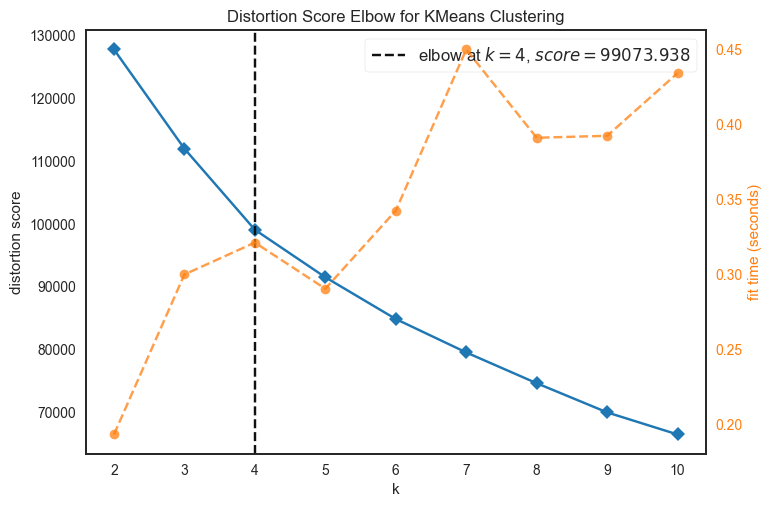

In [18]:
# Show optimal number of clusters
def optimal_number_of_clusters(df: pd.DataFrame) -> int:
    if df is None:
        return 0
    sns.set_style('white')
    sns.set_palette('tab10')

    visualizer = KElbowVisualizer(KMeans(), k=10)
    visualizer.fit(StandardScaler().fit_transform(df.values))
    visualizer.show()

    return int(visualizer.elbow_value_) if visualizer.elbow_value_ is not None else 0


print('Figure 3. Optimal number of clusters')
n_clusters = optimal_number_of_clusters(X)

In [19]:
# Create a pipeline
def create_pipeline(n_clusters: int) -> Pipeline:
    return make_pipeline(StandardScaler(), KMeans(n_clusters=n_clusters))


kmeans_pipe = create_pipeline(n_clusters)

In [20]:
# Table of clusters
def table_of_clusters(df: pd.DataFrame, pipeline: Pipeline) -> style.Styler:
    pipeline.fit(df)

    original = df['Cluster'].\
        value_counts().reset_index().\
        rename(columns={
            'Cluster': 'Original Cluster', 'count': 'Original'
        })
    model = pd.DataFrame(pipeline.named_steps['kmeans'].labels_).\
        value_counts().reset_index().\
        rename(columns={
            0: 'Model Cluster', 'count': 'Model'
        })

    return pd.concat([original, model], axis=1).style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'width': '200px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 4. Table of clusters')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')


table_of_clusters(ml, kmeans_pipe)

,Original Cluster,Original,Model Cluster,Model
0,0,3976,0,3976
1,3,3367,1,3367
2,2,1198,3,1198
3,1,409,2,409


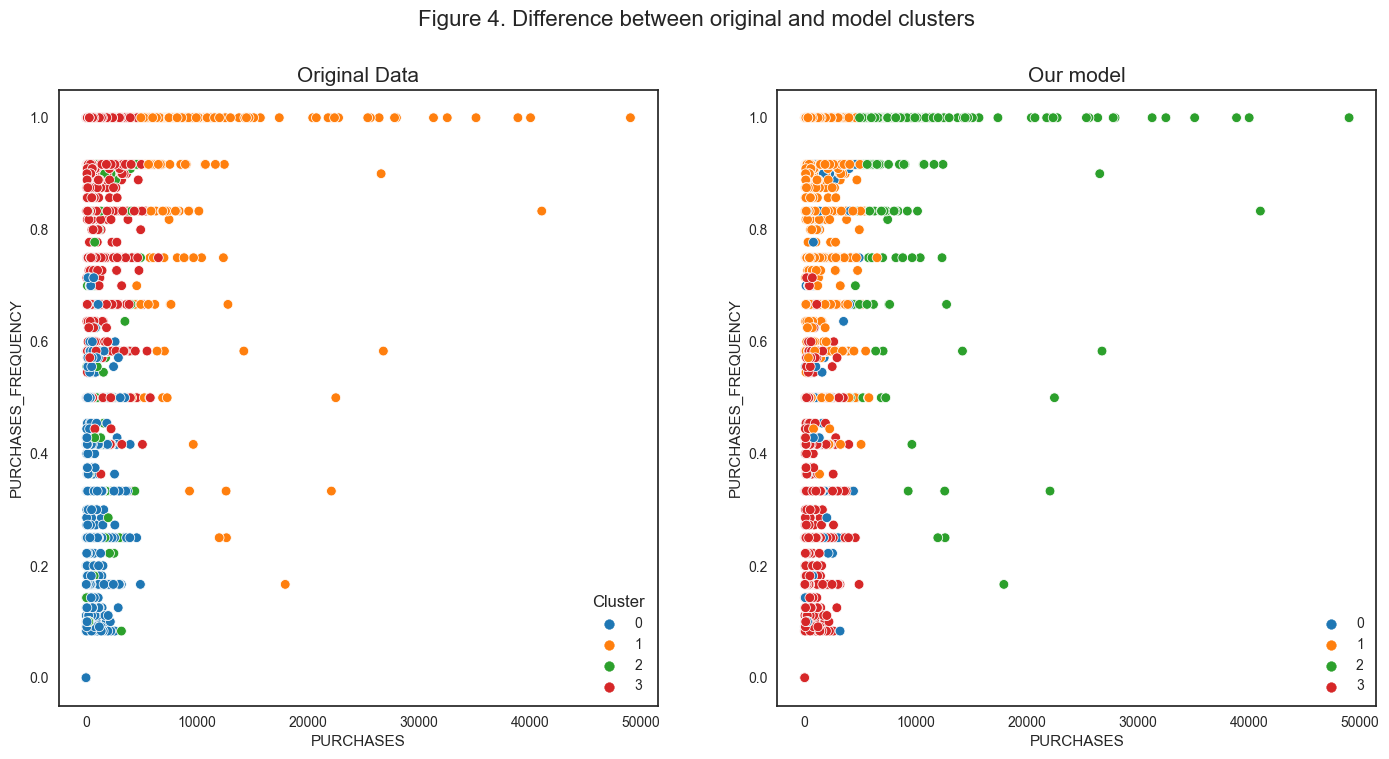

In [21]:
# Plot difference between original and model clusters
def plot_difference_between_original_and_model_clusters(df: pd.DataFrame, pipeline: Pipeline) -> None:
    pipeline.fit(df)
    fig, axes = plt.subplots(1, 2, figsize=(17, 8))

    sns.scatterplot(x='PURCHASES', 
                    y='PURCHASES_FREQUENCY', 
                    data=data, 
                    hue='Cluster', 
                    ax=axes[0], 
                    palette='tab10')
    axes[0].set_title('Original Data', fontsize=15)

    sns.scatterplot(x='PURCHASES', 
                    y='PURCHASES_FREQUENCY', 
                    data=data, 
                    hue=pipeline.named_steps['kmeans'].labels_, 
                    ax=axes[1], 
                    palette='tab10')
    axes[1].set_title('Our model', fontsize=15)

    plt.suptitle('Figure 4. Difference between original and model clusters', fontsize=16)
    plt.show()


plot_difference_between_original_and_model_clusters(ml, kmeans_pipe)

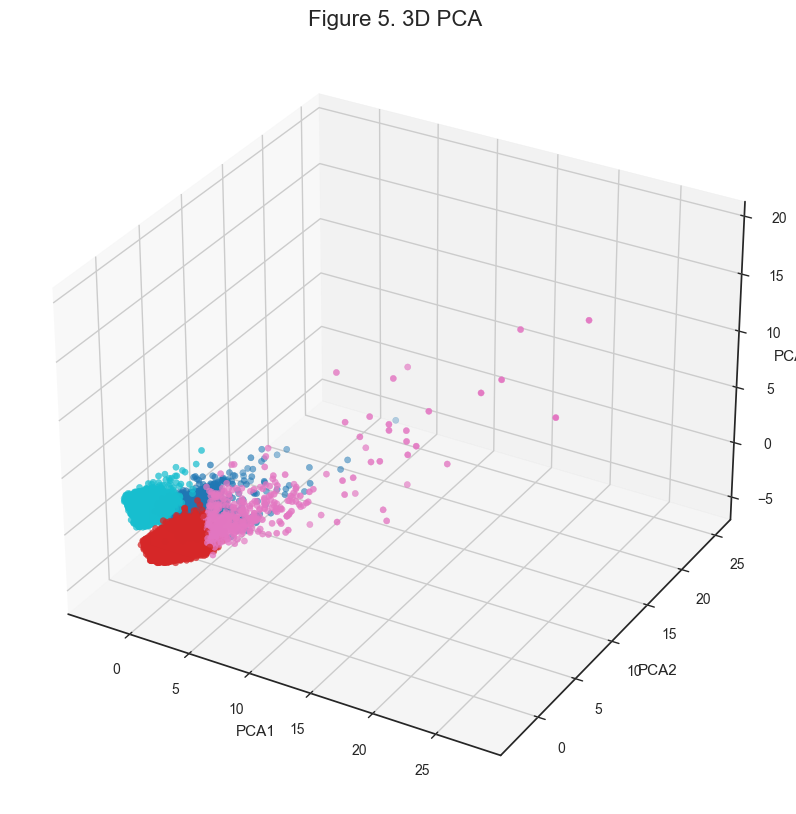

In [22]:
# 3 dimensional pca
def plot_3d_pca(df: pd.DataFrame, pipeline: Pipeline) -> None:
    pipeline.fit(df)

    pca = PCA(n_components=3)
    pca_df = pd.DataFrame(
        pca.fit_transform(
            pipeline.named_steps['standardscaler'].fit_transform(df.values)),
        columns=['PCA1', 'PCA2', 'PCA3'])
    
    sns.set_style('white')
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(pca_df.PCA1, pca_df.PCA2, pca_df.PCA3, c=pipeline.named_steps['kmeans'].labels_, cmap='tab10')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.title('Figure 5. 3D PCA', fontsize=16)
    plt.show()


plot_3d_pca(ml, kmeans_pipe)

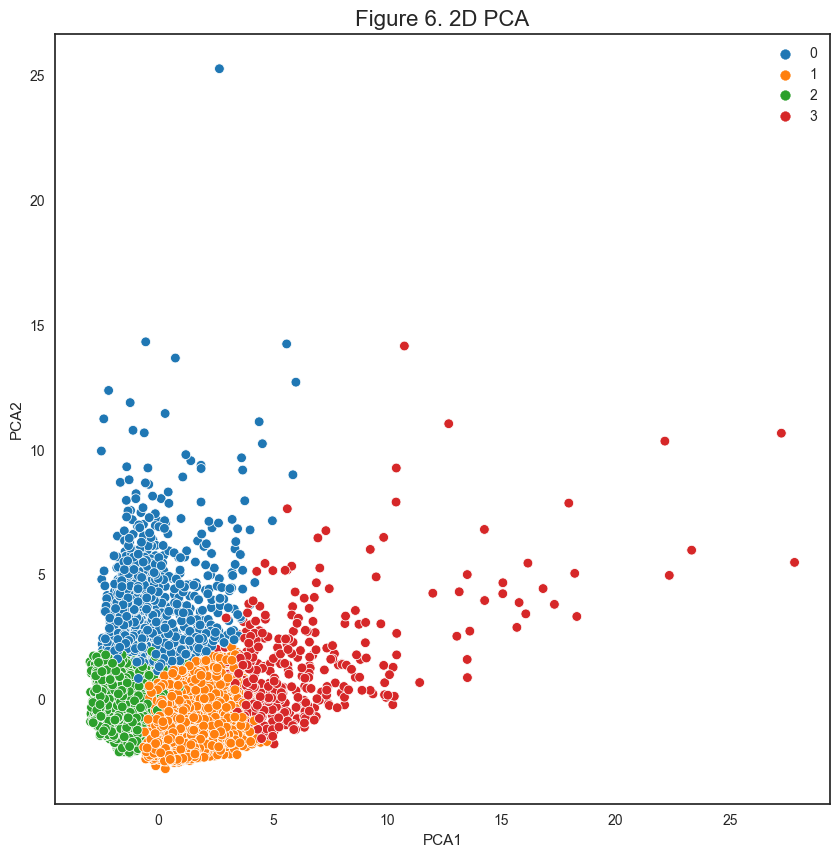

In [23]:
# 2 dimensional pca
def plot_2d_pca(df: pd.DataFrame, pipeline: Pipeline) -> None:
    pipeline.fit(df)

    pca = PCA(n_components=2)
    pca_df = pd.DataFrame(
        pca.fit_transform(
            pipeline.named_steps['standardscaler'].fit_transform(df.values)),
        columns=['PCA1', 'PCA2'])
    
    sns.set_style('white')
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='PCA1', y='PCA2', data=pca_df, hue=pipeline.named_steps['kmeans'].labels_, palette='tab10')
    plt.title('Figure 6. 2D PCA', fontsize=16)
    plt.show()


plot_2d_pca(ml, kmeans_pipe)

## Conclusion

With supervised learning, we choose K-Nearest Neighbors as our final model. With unsupervised learning, we choose K-Means Clustering as our final model. We will use the K-Means Clustering model to segment the customers into different groups and then use the K-Nearest Neighbors model to predict the cluster of new customers.

In [24]:
# Save K-Nearst Neighbors model
def save_knn_model(df: pd.DataFrame, knn: OneVsRestClassifier, path: str) -> None:
    knn.fit(df.drop(columns=['Cluster']), df['Cluster'])
    pickle.dump(knn, open(path, 'wb'))


KNN_PATH = os.getcwd() + '/models/knn'
save_knn_model(ml, pipelines['K Nearest Neighbors'], KNN_PATH)

In [25]:
# Save K-Means model
def save_kmeans_model(df: pd.DataFrame, pipeline: Pipeline, path: str) -> None:
    pipeline.fit(df)
    pickle.dump(pipeline, open(path, 'wb'))


KMEANS_PATH = os.getcwd() + '/models/kmeans'
save_kmeans_model(ml, kmeans_pipe, KMEANS_PATH)

In [26]:
# Load K-Means model
def load_kmeans_model(path: str) -> Pipeline:
    return pickle.load(open(path, 'rb'))

In [27]:
# Load K-Nearest Neighbors model
def load_knn_model(path: str) -> OneVsRestClassifier:
    return pickle.load(open(path, 'rb'))